In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor

from IPython.display import display, HTML

In [446]:
from IPython.display import display, HTML

In [2]:
def error(y, ypred):
    y_new, ypred_new = [], []
    for i, item in enumerate(y):
        if item != 0:
            y_new.append(item)
            ypred_new.append(ypred[i])
    y = np.array(y_new)
    ypred = np.array(ypred_new)
    
    return np.sqrt(1./len(y) * sum(((y - ypred) / y) ** 2))

def process_data(data):
    # Merge store data
    data = data.merge(store, on = 'Store', copy = False)
    
    # Break down date column
    data['year'] = data.Date.apply(lambda x: x.year)
    data['month'] = data.Date.apply(lambda x: x.month)
#     data['dow'] = data.Date.apply(lambda x: x.dayofweek)
    data['woy'] = data.Date.apply(lambda x: x.weekofyear)
    data.drop(['Date'], axis = 1, inplace= True)

    # Calculate time competition open in months
    data['CompetitionOpen'] = 12 * (data.year - data.CompetitionOpenSinceYear) + \
    (data.month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
    data.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis = 1, 
             inplace = True)
    
    # Promo open time
    data['PromoOpen'] = 12 * (data.year - data.Promo2SinceYear) + \
    (data.woy - data.Promo2SinceWeek) / float(4)
    data['PromoOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
    data.drop(['Promo2SinceYear', 'Promo2SinceWeek'], axis = 1, 
             inplace = True)
    
    # Get promo months
    data['p_1'] = data.PromoInterval.apply(lambda x: x[:3] if type(x) == str else 0)
    data['p_2'] = data.PromoInterval.apply(lambda x: x[4:7] if type(x) == str else 0)
    data['p_3'] = data.PromoInterval.apply(lambda x: x[8:11] if type(x) == str else 0)
    data['p_4'] = data.PromoInterval.apply(lambda x: x[12:15] if type(x) == str else 0)
    
    
    # Get dummies
    data = pd.get_dummies(data, columns = ['p_1', 'p_2', 'p_3', 'p_4', 
                                           'StateHoliday' , 
#                                            'dow', 
                                           'StoreType', 
                                           'Assortment'])
    data.drop(['Store',
               'PromoInterval', 
               'p_1_0', 'p_2_0', 'p_3_0', 'p_4_0', 
               'StateHoliday_0', 
               'year'], axis=1,inplace=True)

    # data = data.drop(['dow', 'StateHoliday', 'StoreType', 'Assortment'], axis = 1)
    # #     data.dropna(axis = 1, inplace = True)
    
    # Fill in missing values
    data = data.fillna(0)
    data = data.sort_index(axis=1)
    
    return data

# `Store` EDA

### Summary of `Store` dataset (prior to any processing)

In [465]:
#store = pd.read_csv('store.csv')  
display( store.info())
display( store.describe())
display( store[['StoreType','Assortment','PromoInterval']].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 95.8+ KB


None

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


,StoreType,Assortment,PromoInterval
count,1115,1115,571
unique,4,3,3
top,a,a,"Jan,Apr,Jul,Oct"
freq,602,593,335


### Look at distribution of values for different subsets of the `Store` dataset

In [26]:
### STORE EDA
#store.groupby('StoreType').describe()
#store.groupby('Assortment').describe()
#store.groupby('PromoInterval').describe()
store[store.Promo2==0].describe()
#store.groupby(['StoreType','Assortment']).count()['Store']
#store.groupby(['PromoInterval','StoreType']).count()['Store']
#store.groupby(['PromoInterval','Assortment']).count()['Store']

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,544.000000,542.000000,396.000000,396.000000,544,0,0
mean,555.531250,6549.520295,7.260101,2009.123737,0,NaN,NaN
std,317.491536,9374.321188,3.176739,4.326819,0,NaN,NaN
min,1.000000,30.000000,1.000000,1990.000000,0,NaN,NaN
25%,280.250000,992.500000,4.000000,2006.000000,0,NaN,NaN
50%,559.000000,2640.000000,8.000000,2010.000000,0,NaN,NaN
75%,827.250000,8105.000000,10.000000,2013.000000,0,NaN,NaN
max,1114.000000,75860.000000,12.000000,2015.000000,0,NaN,NaN


Notes:

- **CompetitionDistance**: Only 3 stores are missing a distance. Look at historical sales... is filling with mean distance more appropriate? Currently set to 0.
    
- **Promo2** is a boolean populated for all stores. Only 571 stores have value 1 --> This exactly corresponds with 571 consumers who have non-missing values for the time since and interval variables associated Promo2 (**SinceWeek**, **SinceYear**, **Interval**).

### Histogram of all `Store` variables

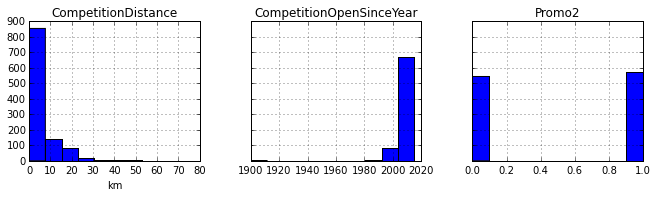

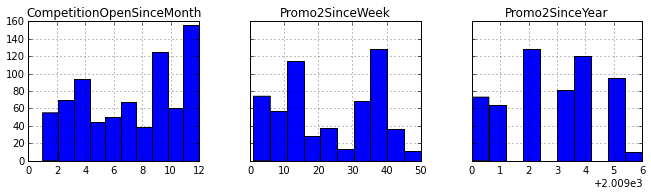

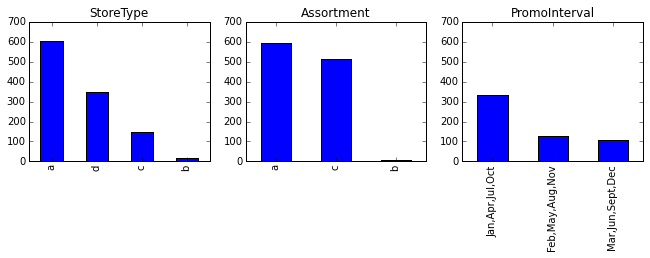

In [521]:
ax = store[['CompetitionDistance','CompetitionOpenSinceYear','Promo2']].hist(sharey=True, figsize=(11,2.5), layout = (1,3));
ax[0][0].set_xticklabels(map(int,ax[0][0].get_xticks()/1000))
ax[0][0].set_xlabel('km')
ax = store[['CompetitionOpenSinceMonth','Promo2SinceWeek','Promo2SinceYear']].hist(sharey=True, figsize=(11,2.5), layout = (1,3));

fig, ax = plt.subplots(1, 3, figsize =(11, 2.5))
# df[['StoreType','Assortment','PromoInterval']].value_counts().plot(kind='bar')
# title('Histogram of events by event type')
for i, col in enumerate(['StoreType','Assortment','PromoInterval']):
    store[col].value_counts().plot(kind='bar', ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_ylim(0, 700)

# Merged EDA

In [424]:
data = pd.read_csv('train.csv', parse_dates = ['Date'])
#data = data[data['Open'] != 0]
store = pd.read_csv('store.csv')  

df = data.merge(store, on = 'Store', copy = False)

### Summary of `Train` dataset (after merge with `Store` dataset -- no other processing)

In [427]:
display( df.info())
display( df.describe())
#print df[['StoreType','Assortment','PromoInterval']].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 no

None

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1014567.000000,693861.000000,693861.000000,1017209.000000,509178.000000,509178.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647,5430.085652,7.222866,2008.690228,0.500564,23.269093,2011.752774
std,321.908651,1.997391,3849.926175,464.411734,0.375539,0.485759,0.383056,7715.323700,3.211832,5.992644,0.500000,14.095973,1.662870
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,280.000000,2.000000,3727.000000,405.000000,1.000000,0.000000,0.000000,710.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.000000,4.000000,5744.000000,609.000000,1.000000,0.000000,0.000000,2330.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,838.000000,6.000000,7856.000000,837.000000,1.000000,1.000000,0.000000,6890.000000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


### Preliminary char-gen for merged `Train` dataset (mainly date processing and filling NAs)

In [522]:
# set index to Date
df = df.set_index('Date')

# extract month, year, week of year and 'bi-week' of year
df['Month'] = df.index.month
df['Year'] = df.index.year
df['woy'] = df.index.weekofyear
df['woy2'] = np.array(np.ceil(df.woy/2.0), dtype=int)

# make a copy of the year column, and reindex to match 'week of year'
#    for example, the last few days of december 2013 are assigned 'week of year' == 1
#    therefore, these days should have woy_yr set to 2014... because they appear in 
#    the first week of 2014 (not the first week of 2013)
df['woy_yr'] = df.index.year
df.loc[np.logical_and(df.Month==12, df.woy==1), 'woy_yr']+= 1
df = df.reset_index()

# Fill PromoInterval missing values with string, so that they can be properly counted 
# as their own category in groupby statements, etc.
df['PromoInterval'] = df['PromoInterval'].fillna('N/A')

# Bin competition distance (for EDA purposes)
#    1 = low   (<1 km)
#    2 = close (1.0 - 2.5 km)
#    3 = mid   (2.5 - 7.5 km)
#    4 = dist  (7.5 - 15. km)
#    5 = far   (> 15 km)
# Note: 3 stores are missing a distance, for now they're assigned the median
#       distance (2.325 km), which puts them in bin 2: "close"
temp_distance = df['CompetitionDistance'].fillna(2325) # Median value
df['DistType'] = pd.cut(temp_distance, 
                        bins=[-1, 1000, 2500, 7500, 15000, 100000], 
                        labels=[1, 2, 3, 4, 5])
df.DistType = np.array(df.DistType.values, np.dtype(int))
#df.DistType = df.DistType.cat.add_categories(['N/A'])

# Copy dataframe, including only open days for each store
df_open = df[df['Open']==1]

### Quick summary of `df_open` dataset (merged `train` data, filtered to include open days for each store)

In [364]:
df_open.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017207
Data columns (total 22 columns):
Date                         844392 non-null datetime64[ns]
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64
Promo                        844392 non-null int64
StateHoliday                 844392 non-null object
SchoolHoliday                844392 non-null int64
StoreType                    844392 non-null object
Assortment                   844392 non-null object
CompetitionDistance          844392 non-null float64
CompetitionOpenSinceMonth    575773 non-null float64
CompetitionOpenSinceYear     575773 non-null float64
Promo2                       844392 non-null int64
Promo2SinceWeek              421085 non-null float64
Promo2SinceYear              421085 non-null float64

### Check for missing dates

In [207]:
print 'Dates range from %s to %s' % (df.Date.min().strftime('%Y-%m-%d'), 
                                     df.Date.max().strftime('%Y-%m-%d'))

Dates range from 2013-01-01 to 2015-07-31


There are 180 stores (see above) that have no reported records from 2014-07-01 to 2014-12-31.


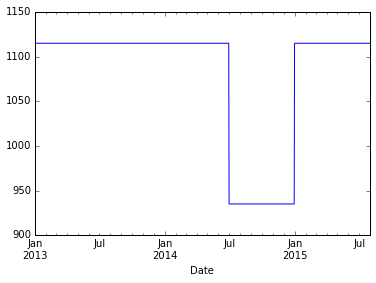

In [138]:
date_ct = df.groupby('Date').count()['Store']
missing = date_ct[date_ct<1000].index
print 'There are 180 stores (see above) that have no reported records from %s to %s.' % \
    (missing.min().strftime('%Y-%m-%d'), missing.max().strftime('%Y-%m-%d'))
    
df.groupby('Date').count()['Store'].plot();

In [524]:
print 'Stores were reported for either 758, 941 or 942 days, as follows: (includes closed days)'
print '    (This is equivalent to number of rows reported for each store)'
display( df.groupby('Store').count().groupby('Date').count()['Sales'])
full_list = df.groupby('Store').count().index[df.groupby('Store').count()['Sales']>800].values

Stores were reported for either 758, 941 or 942 days, as follows: (includes closed days)
    (This is equivalent to number of rows reported for each store)


Date
758    180
941      1
942    934
Name: Sales, dtype: int64

#### Find list of 180 stores that were not reported between 2014-07-01 to 2014-12-31

In [526]:
store_ct = df.query('Month<8').groupby('Store').count()['Date']
missing_stores = store_ct[store_ct<635].index
display(len(missing_stores))

180

#### Find single store that was missing just one day from observation period

In [407]:
print 'Store 988 is missing the first day of record (2013-01-01)'
df.query('Store==988').tail(2)

Store 988 is missing the first day of record (2013-01-01)


,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year,woy,DistType,woy2,woy_yr
901253,2013-01-03,988,4,4335,737,1,0,0,1,a,...,0,NaN,NaN,N/A,1,2013,1,1,1,2013
901254,2013-01-02,988,3,4992,829,1,0,0,1,a,...,0,NaN,NaN,N/A,1,2013,1,1,1,2013


### Find list of stores that were open (and with Sales > 0) for every day in `Train` dataset (2013-01-01 to 2015-7-31)
This list can be used to test models and other analysis without having to clean data

In [418]:
temp = df_open.groupby('Store').count()[['Date']]
temp.sort('Date',inplace=True,ascending=False)
print temp.head(10)

temp = df.groupby('Store').count()[['Date']]
temp.sort('Date',inplace=True,ascending=False)
print temp.head(10)

# 10 stores to test models on: [769, 1097, 85, 562, 262, 733, 494, 682, 335, 423]

       Date
Store      
769     942
1097    942
85      942
562     942
262     942
733     942
494     942
682     942
335     942
423     942
       Date
Store      
1       942
726     942
708     942
709     942
713     942
714     942
715     942
717     942
718     942
720     942


## Set of functions that plot average daily sales / customer cts

In [550]:
def plot_avg_daily(df, avg_cols, label, index2='Month'):
    if type(avg_cols) <> list:
        avg_cols = [avg_cols]
    if index2[:3] == 'woy':
        yr_col = 'woy_yr'
    else:
        yr_col = 'Year'
    df_mo = df.groupby([yr_col,index2,'Store'], as_index=False).mean()
    df_mo2 = df_mo.groupby([yr_col,index2]).mean()[avg_cols]

    df_mo2.plot();
    plt.title('Avg Daily Values across All Stores\n%s' % label);

def plot_avg_daily_grouped(df, avg_col, by_col, index2='Month', plot_all=False):
    if index2[:3] == 'woy':
        yr_col = 'woy_yr'
    else:
        yr_col = 'Year'
    df_mo = df.groupby([yr_col,index2,'Store', by_col], as_index=False).mean()
    df_mo2 = pd.pivot_table(df_mo, values=avg_col, index=[yr_col, index2], 
                            columns=[by_col], aggfunc=np.mean)

    ax = df_mo2.plot();
    if plot_all:
        df_mo = df.groupby([yr_col,index2,'Store'], as_index=False).mean()
        df_mo2 = df_mo.groupby([yr_col,index2]).mean()[avg_col]

        df_mo2.plot(ax=ax);
        
    plt.title('Avg Daily %s across All Stores\nby %s' % (avg_col, by_col));
    
def plot_avg_by_year(df, avg_col, label, index2='Month'):
    if index2[:3] == 'woy':
        yr_col = 'woy_yr'
    else:
        yr_col = 'Year'
    df_mo = df.groupby([yr_col,index2,'Store'], as_index=False).mean()
    df_mo2 = pd.pivot_table(df_mo, values=avg_col, index=[index2], 
                            columns=[yr_col], aggfunc=np.mean)

    df_mo2.plot(figsize=(10,5), grid=True);
    plt.title('Avg Daily Values across All Stores\n%s' % label);
    
def plot_avg_daily_lagged(df, avg_cols, label, index2='Month'):
    if index2[:3] == 'woy':
        yr_col = 'woy_yr'
    else:
        yr_col = 'Year'
    df_mo = df.groupby([yr_col,index2,'Store'], as_index=False).mean()
    df_mo2 = df_mo.groupby([yr_col,index2]).mean()[avg_cols]

    #df_mo2.plot();
    #plt.title('Avg Daily Values across All Stores\n%s' % label);
    
    if index2=='woy':
        x = [x + ((y-1)/52.0) for x, y in df_mo2.index.values[1:]]
    else:
        x = [x + ((y-1)/12.0) for x, y in df_mo2.index.values[1:]]
    y = df_mo2.values[1:]-df_mo2.values[:-1]
    #print x
    plt.figure(figsize=(10,5))
    plt.plot(x,y)
    plt.title('Avg Daily Sales across All Stores\nLagged - %s' % index2);
    plt.xlabel('Date')
    plt.ylabel('Avg. Daily Sales')
    
def plot_avg_daily_deseason(df, avg_cols, label, index2='Month'):
    if index2[:3] == 'woy':
        yr_col = 'woy_yr'
    else:
        yr_col = 'Year'
    df_mo = df.groupby([yr_col,index2,'Store'], as_index=False).mean()
    df_mo2 = df_mo.groupby(['Store',index2], as_index=False).mean()
    df_mo3 = df_mo.groupby([index2]).mean()[avg_cols]
    
    df_mo4 = df_mo.groupby([yr_col,index2]).mean()[avg_cols]
    df_mo5 = df_mo.groupby([yr_col,index2]).mean()[avg_cols]

    #df_mo2.plot();
    #plt.title('Avg Daily Values across All Stores\n%s' % label);
    
    y = df_mo4.values
    if index2[:3]=='woy':
        i1 = len(df_mo3.values)
        i2 = 2*i1
        i3 = len(df_mo4.values) % i1
        x = [a + ((b-1)/float(i1)) for a, b in df_mo4.index.values]
        y[:i1] = y[:i1] - df_mo3.values
        y[i1:i2] = y[i1:i2] - df_mo3.values
        y[i2:] = y[i2:] - df_mo3.values[:i3]
        z = np.vstack([y, df_mo5.values, np.hstack([df_mo3.values, df_mo3.values, df_mo3.values[:i3]])]).T
    else:
        x = [a + ((b-1)/12.0) for a, b in df_mo4.index.values]
        y[:12] = y[:12] - df_mo3.values
        y[12:24] = y[12:24] - df_mo3.values
        y[24:] = y[24:] - df_mo3.values[:7]
        z = np.vstack([y, df_mo5.values, np.hstack([df_mo3.values, df_mo3.values, df_mo3.values[:7]])]).T
    plt.figure(figsize=(10,5))
    plt.plot(x,z)
    plt.legend(['de-seasonalized','unadjusted', 'seasonal mean'],loc='best')
    plt.title('Avg Daily Sales across All Stores\n%s' % index2);
    plt.xlabel('Date')
    plt.ylabel('Avg. Daily Sales')

## Plot Avg Daily Sales, Compared year to year

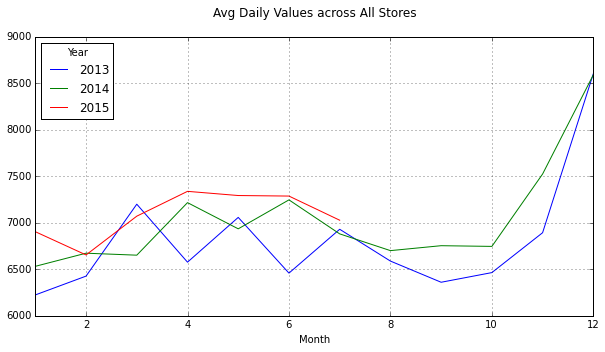

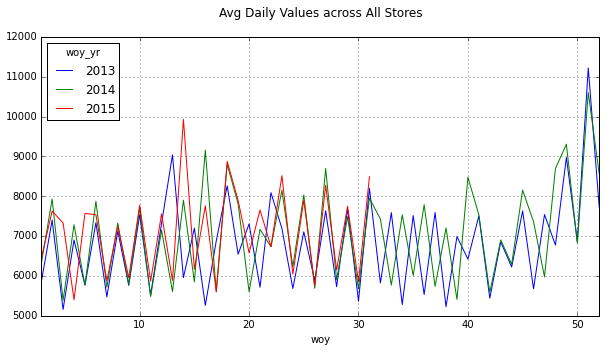

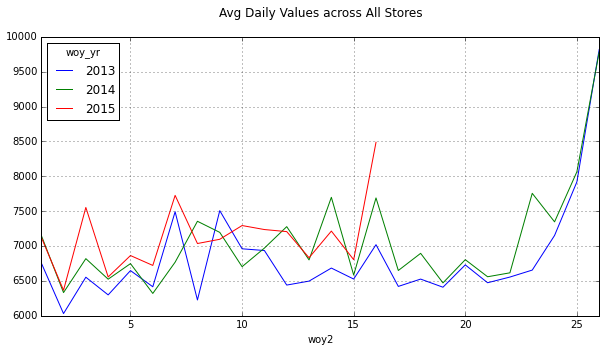

In [551]:
plot_avg_by_year(df_open, 'Sales', '')
plot_avg_by_year(df_open, 'Sales', '', index2='woy')
plot_avg_by_year(df_open, 'Sales', '', index2='woy2')

## Plot Avg Daily Sales, looking at lagged .vs deseasonalized time series

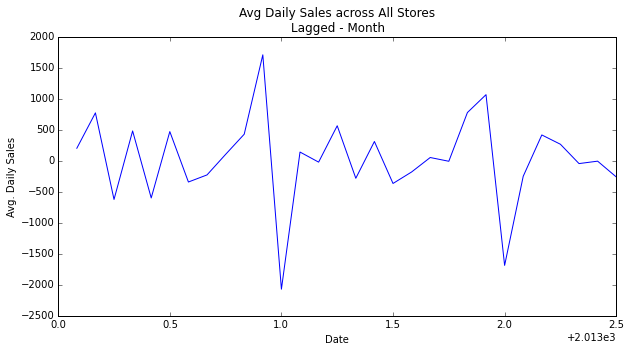

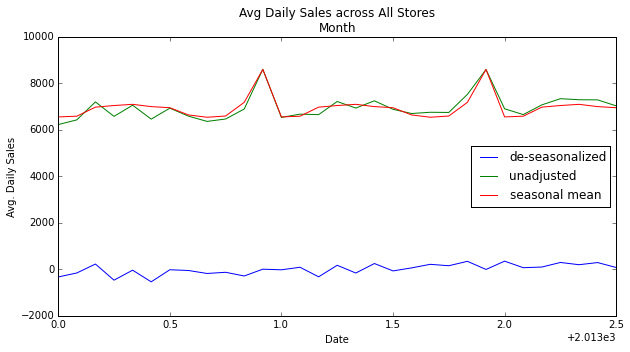

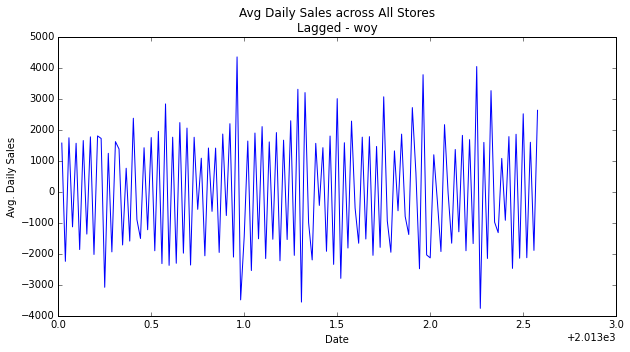

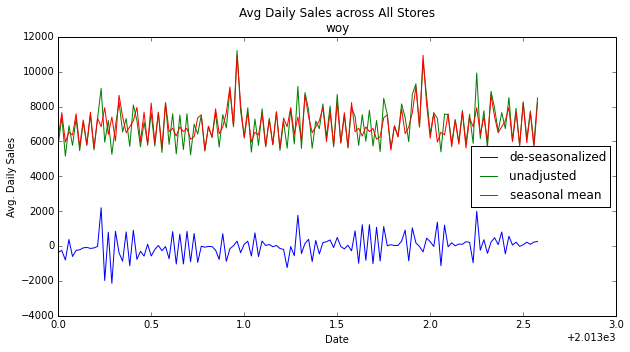

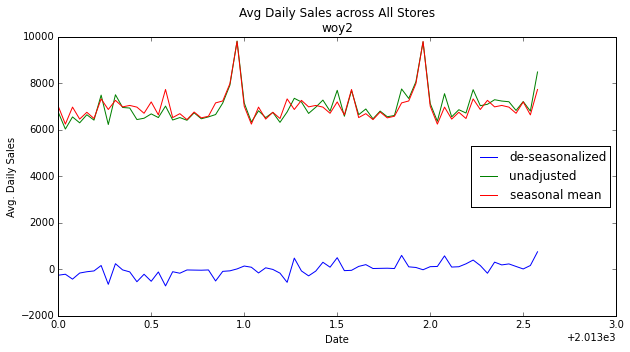

In [552]:
plot_avg_daily_lagged(df_open, 'Sales', '', index2='Month')
plot_avg_daily_deseason(df_open, 'Sales', '', index2='Month')

plot_avg_daily_lagged(df_open, 'Sales', '', index2='woy')
plot_avg_daily_deseason(df_open, 'Sales', '', index2='woy')
plot_avg_daily_deseason(df_open, 'Sales', '', index2='woy2')

## Compare Sales at stores

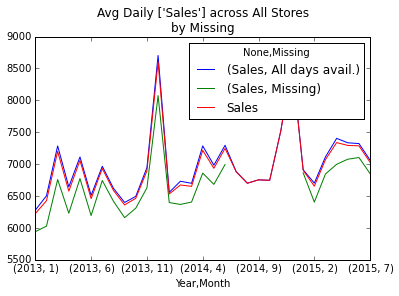

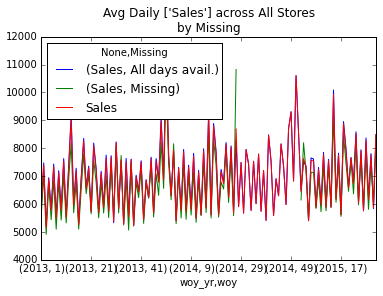

In [554]:
# set of stores that were reported for all days 
# (i.e. excluding 180 stores that are 'missing' for last half of 2014)
df_full = df_open.copy()
df_full['Missing'] = df_full['Store'].isin(set(missing_stores)).apply(lambda x: 'Missing' if x else 'All days avail.')
#df_full.groupby('Missing').count()

plot_avg_daily_grouped(df_full, ['Sales'], 'Missing', plot_all=True)
#plot_avg_daily(df_full, ['Sales','Customers'], '(only the 935 reported over full period)')

plot_avg_daily_grouped(df_full, ['Sales'], 'Missing', index2='woy', plot_all=True)
#plot_avg_daily(df_full, ['Sales','Customers'], '(only the 935 reported over full period)', index2='woy')

NOTE: StoreType b and Assortment b are both a very small subset of the data


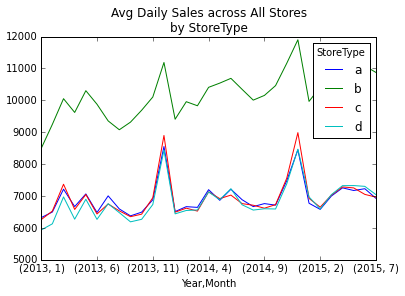

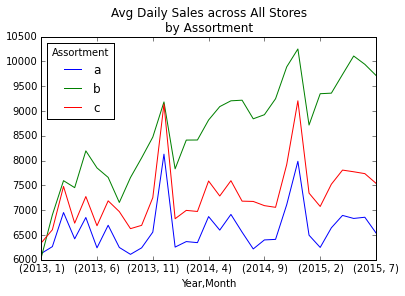

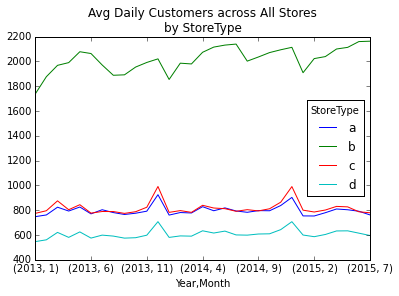

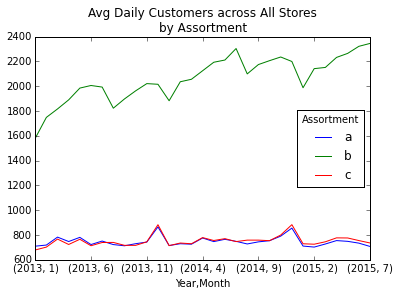

In [386]:
#df_open = df[df['Open']==1]
print 'NOTE: StoreType b and Assortment b are both a very small subset of the data'
plot_avg_daily_grouped(df_open, 'Sales', 'StoreType')
plot_avg_daily_grouped(df_open, 'Sales', 'Assortment')
plot_avg_daily_grouped(df_open, 'Customers', 'StoreType')
plot_avg_daily_grouped(df_open, 'Customers', 'Assortment')

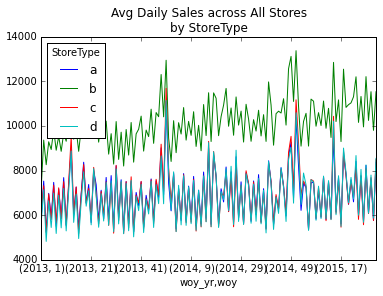

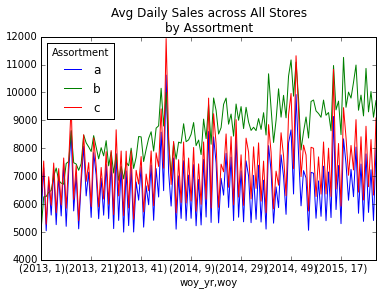

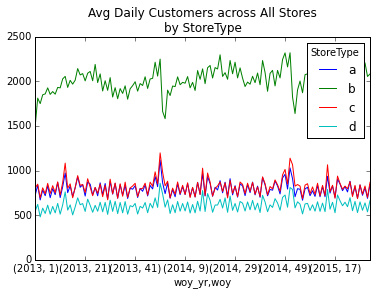

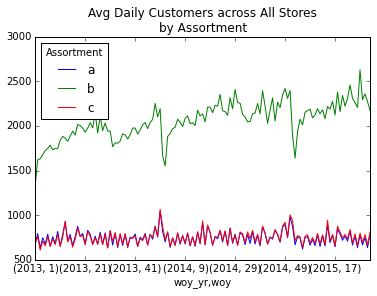

In [387]:

plot_avg_daily_grouped(df_open, 'Sales', 'StoreType', index2='woy')
plot_avg_daily_grouped(df_open, 'Sales', 'Assortment', index2='woy')
plot_avg_daily_grouped(df_open, 'Customers', 'StoreType', index2='woy')
plot_avg_daily_grouped(df_open, 'Customers', 'Assortment', index2='woy')

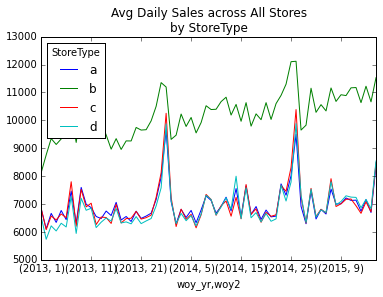

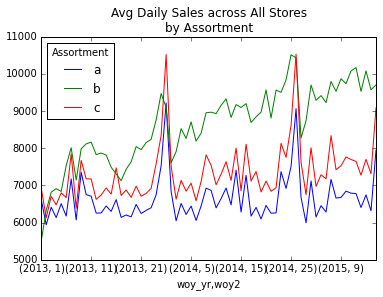

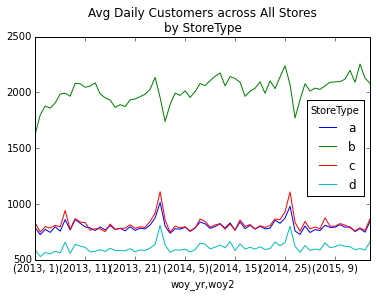

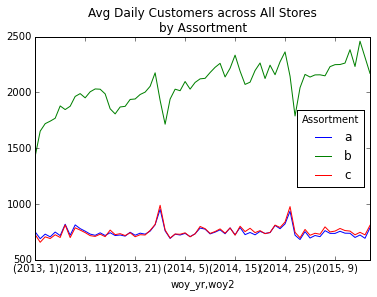

In [388]:

plot_avg_daily_grouped(df_open, 'Sales', 'StoreType', index2='woy2')
plot_avg_daily_grouped(df_open, 'Sales', 'Assortment', index2='woy2')
plot_avg_daily_grouped(df_open, 'Customers', 'StoreType', index2='woy2')
plot_avg_daily_grouped(df_open, 'Customers', 'Assortment', index2='woy2')

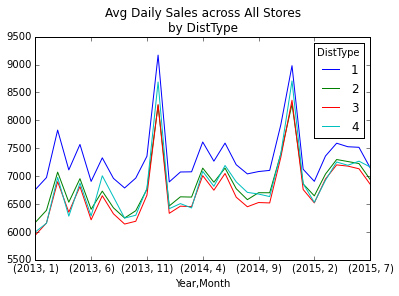

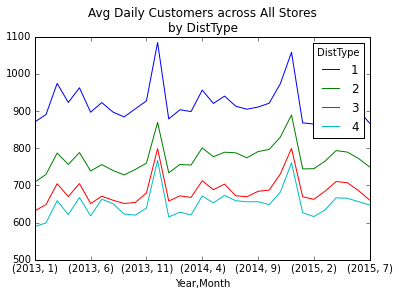

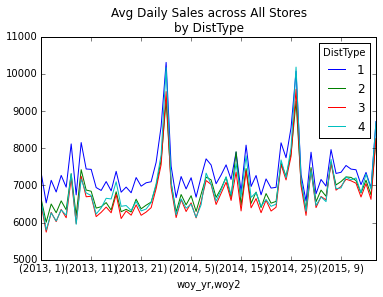

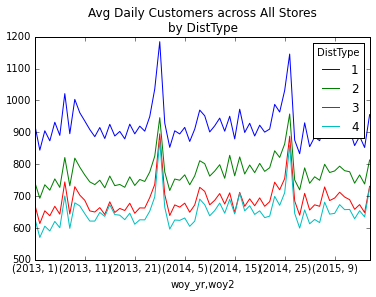

In [389]:
plot_avg_daily_grouped(df_open, 'Sales', 'DistType')
plot_avg_daily_grouped(df_open, 'Customers', 'DistType')

plot_avg_daily_grouped(df_open, 'Sales', 'DistType', index2='woy2')
plot_avg_daily_grouped(df_open, 'Customers', 'DistType', index2='woy2')

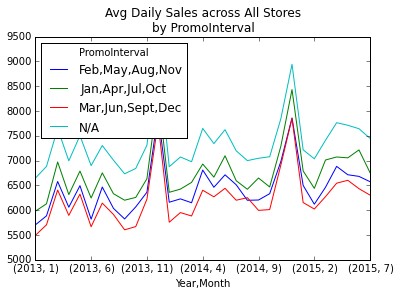

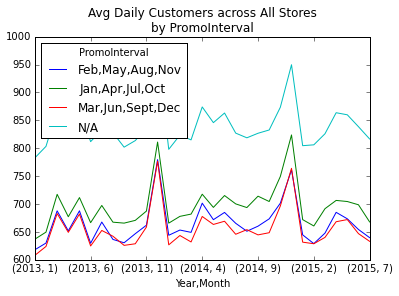

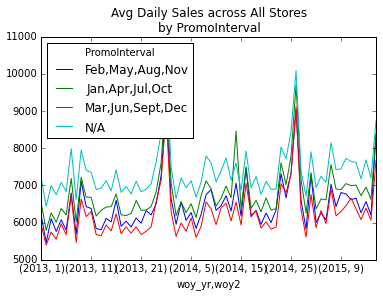

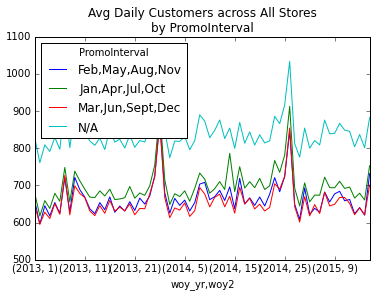

In [390]:
# Promo intervals:
plot_avg_daily_grouped(df_open, 'Sales', 'PromoInterval')
plot_avg_daily_grouped(df_open, 'Customers', 'PromoInterval')

plot_avg_daily_grouped(df_open, 'Sales', 'PromoInterval', index2='woy2')
plot_avg_daily_grouped(df_open, 'Customers', 'PromoInterval', index2='woy2')

In [212]:
print df_open.query('DayOfWeek==7')[['StoreType','Assortment']].describe()

day_str = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
test2 = store[['Store', 'StoreType','Assortment']].set_index('Store')
test2.columns = ['Type',"Ass't"]
for i, s in enumerate(day_str):
    temp = df_open.loc[df_open.DayOfWeek==(i+1),['Store','Date']].groupby('Store').count()
    temp.columns = ['ct_'+s]
    test2 = test2.merge(temp, how='right', left_index=True, right_index=True, copy = False)
    
print 'There are %d stores that are open on Sundays\n' % sunday_count.count().values[0]
print 'The following stores are open on every day of the week, with the given frequency: \n', test2


       StoreType Assortment
count       3593       3593
unique         3          3
top            b          c
freq        2216       1405
There are 33 stores that are open on Sundays

The following stores are open on every day of the week, with the given frequency: 
      Type Ass't  ct_Mon  ct_Tue  ct_Wed  ct_Thu  ct_Fri  ct_Sat  ct_Sun
Store                                                                   
85       b     a     134     135     135     135     135     134     134
122      a     c     134     134     132     131     130     134      90
209      a     c     134     134     132     131     130     134      87
259      b     b     132     133     133     134     134     133     133
262      b     a     134     135     135     135     135     134     134
274      b     b     133     134     134     133     133     132     133
299      d     c     134     134     132     131     131     134      86
310      a     c     134     134     132     131     130     134     102
3

In [441]:
temp = df.query('Month >= 8 and Month <= 9')[['Store','Date','StateHoliday']]

Store  Month
1      8        0
       9        0
2      8        0
       9        0
3      8        0
       9        0
4      8        0
       9        0
5      8        0
       9        0
6      8        0
       9        0
7      8        0
       9        0
8      8        0
       9        0
9      8        0
       9        0
10     8        0
       9        0
11     8        0
       9        0
12     8        0
       9        0
13     8        a
       9        0
14     8        0
       9        0
15     8        0
       9        0
               ..
1101   8        0
       9        0
1102   8        a
       9        0
1103   8        0
       9        0
1104   8        a
       9        0
1105   8        0
       9        0
1106   8        0
       9        0
1107   8        a
       9        0
1108   8        0
       9        0
1109   8        a
       9        0
1110   8        0
       9        0
1111   8        0
       9        0
1112   8        0
       9       

In [434]:
df.query('Month >= 8 and Month <= 9').groupby(['Store','Month']).sum().loc[:,['Promo','SchoolHoliday','StateHoliday']]

Promo  SchoolHoliday  StateHoliday
Store Month                                    
1     8         23             47           NaN
      9         22              5           NaN
2     8         23             38           NaN
      9         22              0           NaN
3     8         23             35           NaN
      9         22              2           NaN
4     8         23             18           NaN
      9         22              1           NaN
5     8         23             38           NaN
      9         22              0           NaN
6     8         23             38           NaN
      9         22              0           NaN
7     8         23             18           NaN
      9         22              0           NaN
8     8         23             18           NaN
      9         22              0           NaN
9     8         23             35           NaN
      9         22              2           NaN
10    8         23             38           NaN
      9         22             10           NaN
11    8         23             18           NaN
      9         22              0           NaN
12    8         23             18           NaN
      9         22              0           NaN
13    8         12             22           NaN
      9         10              8           NaN
14    8         23             35           NaN
      9         22              2           NaN
15    8         23             18           NaN
      9         22              0           NaN
...            ...            ...           ...
1101  8         23             18           NaN
      9         22              0           NaN
1102  8         12             22           NaN
      9         10              8           NaN
1103  8         23             47           NaN
      9         22              5           NaN
1104  8         12             22           NaN
      9         10              8           NaN
1105  8         23             35           NaN
      9         22              2           NaN
1106  8         23             18           NaN
      9         22              0           NaN
1107  8         12             22           NaN
      9         10              8           NaN
1108  8         23             38           NaN
      9         22              0           NaN
1109  8         12             22           NaN
      9         10              8           NaN
1110  8         23             18           NaN
      9         22              1           NaN
1111  8         23             35           NaN
      9         22              2           NaN
1112  8         23             35           NaN
      9         22              2           NaN
1113  8         23             18           NaN
      9         22              0           NaN
1114  8         23             14           NaN
      9         22              1           NaN
1115  8         23             47           NaN
      9         22              5           NaN

[2230 rows x 3 columns]

### Count of Unique Stores, compared across datasets

In [464]:
# Save set of all Stores in test dataset
test = pd.read_csv('test.csv', parse_dates = ['Date'])
test_stores = set(test.Store.unique())

# Save set of all Stores in train dataset
train_stores = set(df.Store.unique())

# Save set of all Stores in train dataset that are missing between Jul-2014 : Dec-2014
store_ct = df.query('Month<8').groupby('Store').count()['Date']
missing = set(store_ct[store_ct<635].index)

# Save set of all stores in both train and test datasets
both_stores = test_stores.intersection(train_stores)

# Save set of all stores in test dataset that are missing from the training dataset betw. Jul14:Dec14
test_stores_missing = test_stores.intersection(missing)

print '                            # Stores in each dataset'
print '                            ------------------------'
print '                               Train   Both   Test'
print '                       Total:   %d    %d    %d' % (len(train_stores), len(both_stores), len(test_stores))
print 'Missing Jul-2014 to Dec-2014:    %d    %d    %d' % (len(missing), len(test_stores_missing), len(test_stores_missing))

                            # Stores in each dataset
                            ------------------------
                               Train   Both   Test
                       Total:   1115    856    856
Missing Jul-2014 to Dec-2014:    180    180    180


In [457]:
1115-856

259

In [3]:
data = pd.read_csv('train.csv', parse_dates = ['Date'])
data = data[data['Open'] != 0]
store = pd.read_csv('store.csv')  

data = process_data(data)

data.describe()
#data.info()

/Users/tracy/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,Assortment_a,Assortment_b,Assortment_c,CompetitionDistance,CompetitionOpen,Customers,DayOfWeek,Open,Promo,Promo2,...,p_2_Apr,p_2_Jun,p_2_May,p_3_Aug,p_3_Jul,p_3_Sep,"p_4_,De",p_4_Nov,p_4_Oct,woy
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392,844392.000000,844392.000000,...,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,0.526899,0.009725,0.463376,5443.849764,41.953548,762.728395,3.520361,1,0.446352,0.498684,...,0.287083,0.095535,0.116066,0.116066,0.287083,0.095535,0.095535,0.116066,0.287083,23.646801
std,0.499276,0.098136,0.498657,7804.251737,65.189741,401.227674,1.723689,0,0.497114,0.499999,...,0.452401,0.293953,0.320304,0.320304,0.452401,0.293953,0.293953,0.320304,0.452401,14.389785
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,700.000000,0.000000,519.000000,2.000000,1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000
50%,1.000000,0.000000,0.000000,2320.000000,16.000000,676.000000,3.000000,1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000
75%,1.000000,0.000000,1.000000,6880.000000,73.000000,893.000000,5.000000,1,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,35.000000
max,1.000000,1.000000,1.000000,75860.000000,1386.000000,7388.000000,7.000000,1,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,52.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 34 columns):
Assortment_a           844392 non-null float64
Assortment_b           844392 non-null float64
Assortment_c           844392 non-null float64
CompetitionDistance    844392 non-null float64
CompetitionOpen        844392 non-null float64
Customers              844392 non-null int64
DayOfWeek              844392 non-null int64
Open                   844392 non-null int64
Promo                  844392 non-null int64
Promo2                 844392 non-null int64
PromoOpen              844392 non-null float64
Sales                  844392 non-null int64
SchoolHoliday          844392 non-null int64
StateHoliday_a         844392 non-null float64
StateHoliday_b         844392 non-null float64
StateHoliday_c         844392 non-null float64
StoreType_a            844392 non-null float64
StoreType_b            844392 non-null float64
StoreType_c            844392 non-null float64
StoreType_

In [45]:
from sklearn.cross_validation import train_test_split

X = data.drop(['Sales', 'Customers'], axis = 1)
y = data.Sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4)

model = RandomForestRegressor(n_jobs = -1, n_estimators = 15)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [46]:
print error(y_test, ypred)

0.295259433432


In [47]:
X.columns[np.argsort(model.feature_importances_)[::-1][:10]]

Index([u'CompetitionDistance', u'Promo', u'DayOfWeek', u'woy', u'PromoOpen',
       u'CompetitionOpen', u'StoreType_b', u'month', u'Promo2',
       u'StoreType_a'],
      dtype='object')

In [48]:
test = pd.read_csv('test.csv', parse_dates = ['Date'])
test = process_data(test)

for col in data.columns:
    if col not in test.columns:
        test[col] = np.zeros(test.shape[0])
        
test = test.sort_index(axis=1).set_index('Id')

In [50]:
test_X = test.drop(['Store','Sales', 'Customers'], axis=1).values

ytest = model.predict(test_X)

In [51]:
result = pd.DataFrame({'Id': test.index.values, 'Sales': ytest}).set_index('Id')
result = result.sort_index()
result.to_csv('predictions.csv')

In [256]:
test = pd.read_csv('test.csv', parse_dates = ['Date'])
test.merge(store, on = 'Store', copy = False).drop(['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1).set_index('Id')

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
Id,,,,,,,,,,,,,
1,1,4,2015-09-17,1,1,0,0,c,a,1270,9,2008,0
857,1,3,2015-09-16,1,1,0,0,c,a,1270,9,2008,0
1713,1,2,2015-09-15,1,1,0,0,c,a,1270,9,2008,0
2569,1,1,2015-09-14,1,1,0,0,c,a,1270,9,2008,0
3425,1,7,2015-09-13,0,0,0,0,c,a,1270,9,2008,0
4281,1,6,2015-09-12,1,0,0,0,c,a,1270,9,2008,0
5137,1,5,2015-09-11,1,0,0,0,c,a,1270,9,2008,0
5993,1,4,2015-09-10,1,0,0,0,c,a,1270,9,2008,0
6849,1,3,2015-09-09,1,0,0,0,c,a,1270,9,2008,0


<Container object of 39 artists>

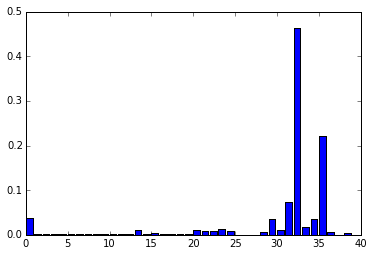

In [436]:
imps = model.feature_importances_[::-1]
x_imps = np.arange(len(imps))

plt.bar(x_imps, imps)

In [441]:
top_X = data.drop(['Sales','Customers'], axis=1).iloc[:, np.argsort(model.feature_importances_)[::-1][:10]]

top_X_train, top_X_test, y_train, y_test = train_test_split(top_X, y)

top_model = RandomForestRegressor(n_jobs = -1)
top_model.fit(top_X_train, y_train)
top_pred = top_model.predict(top_X_test)
print error(top_pred, y_test)

0.239191469141


In [448]:
top_test_X = test.drop(['Sales', 'Customers'], axis=1).iloc[:, np.argsort(model.feature_importances_)[::-1][:10]]

top_model.predict(top_test_X)

array([ 4849.9 ,  4942.3 ,  5475.2 , ...,  7779.91,     0.  ,  5388.06])

In [452]:
from sklearn.cross_validation import cross_val_score

cvs = cross_val_score(estimator=RandomForestRegressor(n_jobs = -1, n_estimators = 50), 
                      X = top_X,
                      y = y,
                      cv = 3,
                      n_jobs = -1,
                      verbose = 1)
print cvs

[Parallel(n_jobs=-1)]: Done   1 out of   3 | elapsed:  4.9min remaining:  9.8min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.0min finished


[ 0.38614541  0.3165081   0.36230987]


In [453]:
from sklearn.ensemble import GradientBoostingRegressor

gdb = GradientBoostingRegressor()
gdb.fit(top_X_train, y_train)

0.239191469141


In [454]:
gdb_pred = gdb.predict(top_X_test)
print error(gdb_pred, y_test)

0.52931310572


In [455]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada = AdaBoostRegressor(DecisionTreeRegressor())
ada.fit(top_X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)

In [456]:
ada_pred = ada.predict(top_X_test)
print error(ada_pred, y_test)

0.246343607065


array([[  1.,   0.,   0., ...,   0.,   0.,  23.],
       [  1.,   0.,   0., ...,   0.,   1.,  23.],
       [  1.,   0.,   0., ...,   0.,   1.,  23.],
       ..., 
       [  0.,   0.,   1., ...,   0.,   0.,  23.],
       [  0.,   0.,   1., ...,   0.,   0.,  23.],
       [  0.,   0.,   1., ...,   0.,   0.,  23.]])